In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

#### Kolmogorov-Smirnov (K-S) Test:

It is a nonparametric statistical test that is used to determine whether two sets of data come from the same distribution. It is often used to test whether a sample of data comes from a specific population or to compare two samples to determine if they come from the same population.

The null hypothesis in this test is that the distributions are the same. If this hypothesis is rejected, it suggests that there is a drift in the model.


Reference: (https://www.statology.org/kolmogorov-smirnov-test-python/#:~:text=The%20Kolmogorov%2DSmirnov%20test%20is,one%2Dsample%20test%20or%20scipy.)

##### 1. One Sample K-S Test:

In [2]:
# Setting the seed for code reproducibility
np.random.seed(123)

#generate dataset of 100 values that follow a Poisson distribution with mean=5
data = pd.DataFrame(np.random.poisson(lam=5,size=100), columns=['arrival_time'])
print(data.shape)
data.head()

(100, 1)


,arrival_time
0,7
1,5
2,4
3,8
4,4


In [3]:
# Perform Kolmogorov-Smirnov test to check if the arrival_time is from a normal distribution

test_obj = stats.kstest(data, 'norm',N=100)
test_obj

KstestResult(statistic=1.0, pvalue=0.0)

In [4]:
np.round(test_obj.pvalue,3)

0.0

##### 2. Two Sample K-S Test:

In [6]:
# Setting the seed for code reproducibility
np.random.seed(123)

#generate dataset of 100 values that follow a Poisson distribution
data1 = pd.DataFrame(np.random.poisson(lam=5,size=100), columns=['arrival_time'])
# data2 = pd.DataFrame(np.random.normal(7,2,100), columns=['arrival_time'])
data2 = pd.DataFrame(np.random.poisson(lam=5,size=100), columns=['arrival_time'])
print(data1.shape)
display(data1.head())
print(data2.shape)
display(data2.head())

(100, 1)


,arrival_time
0,7
1,5
2,4
3,8
4,4


(100, 1)


,arrival_time
0,4
1,4
2,9
3,6
4,7


In [49]:
# Perform Kolmogorov-Smirnov test to check if the arrival_time from two experiments is same or not

test_obj = stats.ks_2samp(data1.arrival_time, data2.arrival_time)
test_obj

KstestResult(statistic=0.14, pvalue=0.2819416298082479)

In [50]:
np.round(test_obj.pvalue,4)

0.2819

#### Population Stability Index (PSI):

Population stability Index (PSI) is a model monitoring metric that is used to quantify how much the distribution of a continuous response variable has changed between two given samples, typically collected at different points in time.

A high PSI value indicates that there is a significant difference between the distributions of the variable in the two datasets, which may suggest that there is a drift in the model. 


* PSI < 0.1: No major change, you can continue with the current model.

* PSI < 0.2: Moderate population change, use your best judgement.

* PSI >= 0.2: Significant population change, model retraining may be required.

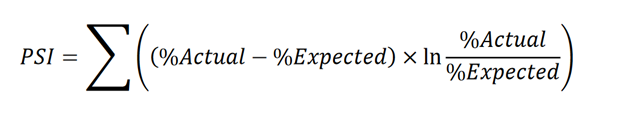

Reference: (https://github.com/mwburke/population-stability-index/blob/master/walkthrough-example.ipynb)

In [7]:
import numpy as np

def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [66]:
# Setting the seed for code reproducibility
np.random.seed(123)

#generate dataset of 100 values that follow a Poisson distribution with mean=5
data1 = pd.DataFrame(np.random.poisson(lam=5,size=100), columns=['arrival_time'])
# data1 = pd.DataFrame(np.random.normal(7,2,100), columns=['arrival_time'])
data2 = pd.DataFrame(np.random.normal(7,2,100), columns=['arrival_time'])
print(data1.shape)
display(data1.head())
print(data2.shape)
display(data2.head())

(100, 1)


,arrival_time
0,4.828739
1,8.994691
2,7.565957
3,3.987411
4,5.842799


(100, 1)


,arrival_time
0,4.828739
1,8.994691
2,7.565957
3,3.987411
4,5.842799


In [67]:
psi_val = calculate_psi(data1.arrival_time,data2.arrival_time)
print(psi_val)

0.0


/var/folders/v_/spfwys4n1gx3khydz8k555rc0000gn/T/ipykernel_15552/3378259138.py:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))


#### Kullback-Leibler Divergence:

The Kullback-Leibler divergence is a measure of the difference between two probability distributions, with a higher divergence indicating a greater degree of difference between the distributions. 

If the divergence is above a certain threshold, this could indicate that there is a drift in the data.


The KL divergence between two distributions Q and P is often stated using the following notation:

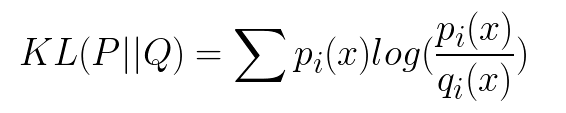

The intuition for the KL divergence score is that when the probability for an event from P is large, but the probability for the same event in Q is small, there is a large divergence. When the probability from P is small and the probability from Q is large, there is also a large divergence, but not as large as the first case.

It can be used to measure the divergence between discrete and continuous probability distributions, where in the latter case the integral of the events is calculated instead of the sum of the probabilities of the discrete events.

The log can be base-2 to give units in “bits,” or the natural logarithm base-e with units in “nats.” When the score is 0, it suggests that both distributions are identical, otherwise the score is positive.

Resource Link: (https://machinelearningmastery.com/divergence-between-probability-distributions/)

In [70]:
# example of calculating the kl divergence between two mass functions
from math import log2

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

# define distributions
p = [0.10, 0.40, 0.50]
q = [0.80, 0.15, 0.05]
# calculate (P || Q)
kl_pq = kl_divergence(p, q)
print('KL(P || Q): %.3f bits' % kl_pq)
# calculate (Q || P)
kl_qp = kl_divergence(q, p)
print('KL(Q || P): %.3f bits' % kl_qp)

KL(P || Q): 0.000 bits
KL(Q || P): 0.000 bits


In [69]:
# example of calculating the kl divergence (relative entropy) with scipy
from scipy.special import rel_entr
# define distributions
p = [0.10, 0.40, 0.50]
q = [0.80, 0.15, 0.05]
# calculate (P || Q)
kl_pq = rel_entr(p, q)
print('KL(P || Q): %.3f nats' % sum(kl_pq))
# calculate (Q || P)
kl_qp = rel_entr(q, p)
print('KL(Q || P): %.3f nats' % sum(kl_qp))

KL(P || Q): 1.336 nats
KL(Q || P): 1.401 nats


#### Jensen-Shannon Divergence:

It is defined as the average of the Kullback-Leibler divergences between the two distributions and a third distribution that is the average of the two. 

The Jensen-Shannon divergence is always non-negative and takes on a value of zero if and only if the two distributions are identical.


It uses the KL divergence to calculate a normalized score that is symmetrical. This means that the divergence of P from Q is the same as Q from P, or stated formally:

**JS(P || Q) == JS(Q || P)**

The JS divergence can be calculated as follows:

**JS(P || Q) = 1/2 * KL(P || M) + 1/2 * KL(Q || M)**

Where M is calculated as:

**M = 1/2 * (P + Q)**

It is more useful as a measure as it provides a smoothed and normalized version of KL divergence, with scores between 0 (identical) and 1 (maximally different), when using the base-2 logarithm.

The square root of the score gives a quantity referred to as the Jensen-Shannon distance, or JS distance for short.

In [71]:
# example of calculating the js divergence between two mass functions
from math import log2
from math import sqrt
from numpy import asarray

# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

# calculate the js divergence
def js_divergence(p, q):
	m = 0.5 * (p + q)
	return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

# define distributions
p = asarray([0.10, 0.40, 0.50])
q = asarray([0.80, 0.15, 0.05])
# calculate JS(P || Q)
js_pq = js_divergence(p, q)
print('JS(P || Q) divergence: %.3f bits' % js_pq)
print('JS(P || Q) distance: %.3f' % sqrt(js_pq))
# calculate JS(Q || P)
js_qp = js_divergence(q, p)
print('JS(Q || P) divergence: %.3f bits' % js_qp)
print('JS(Q || P) distance: %.3f' % sqrt(js_qp))

JS(P || Q) divergence: 0.420 bits
JS(P || Q) distance: 0.648
JS(Q || P) divergence: 0.420 bits
JS(Q || P) distance: 0.648


In [72]:
# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
from numpy import asarray
# define distributions
p = asarray([0.10, 0.40, 0.50])
q = asarray([0.80, 0.15, 0.05])
# calculate JS(P || Q)
js_pq = jensenshannon(p, q, base=2)
print('JS(P || Q) Distance: %.3f' % js_pq)
# calculate JS(Q || P)
js_qp = jensenshannon(q, p, base=2)
print('JS(Q || P) Distance: %.3f' % js_qp)

JS(P || Q) Distance: 0.648
JS(Q || P) Distance: 0.648


#### Wasserstein Distance:

The Wasserstein distance is a measure of the distance between two probability distributions, with a higher distance indicating a greater degree of difference between the distributions. If the distance is above a certain threshold, this could indicate that there is a drift in the data.

It is important to note that the Wasserstein distance requires the input data to be one-dimensional and non-negative.

This distance is also known as the earth mover’s distance, since it can be seen as the minimum amount of “work” required to transform 'u' into 'v', where “work” is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.


Reference: (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html)

In [75]:
# Setting the seed for code reproducibility
np.random.seed(123)

#generate dataset of 100 values that follow a Poisson distribution with mean=5
data1 = pd.DataFrame(np.random.poisson(lam=5,size=100), columns=['arrival_time'])
data2 = pd.DataFrame(np.random.normal(7,2,100), columns=['arrival_time'])
print(data1.shape)
display(data1.head())
print(data2.shape)
display(data2.head())

(100, 1)


,arrival_time
0,7
1,5
2,4
3,8
4,4


(100, 1)


,arrival_time
0,4.899562
1,8.135760
2,8.025966
3,6.946155
4,7.623163


In [76]:
# Compute the first Wasserstein distance between two 1D distributions.

wd = stats.wasserstein_distance(data1.arrival_time,data2.arrival_time)
print("For different distributions: "+str(wd))

wd = stats.wasserstein_distance(data1.arrival_time,data1.arrival_time)
print("For same distributions: "+str(wd))

For different distributions: 2.1791090152734203
For same distributions: 0.0


#### Chi-Square Test:

A Chi-Square Goodness of Fit Test is used to determine whether or not a categorical variable follows a hypothesized distribution.

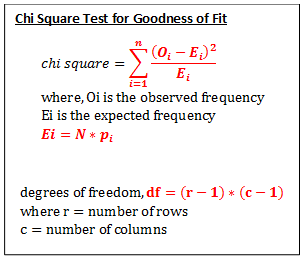

**Null:** A variable follows a hypothesized distribution

**Alternate:** A variable does not follows a hypothesized distribution

The chi-square provides a way to test how well a sample of data matches the characteristics of the larger population that the sample is intended to represent. The sample data cannot be used to draw conclusions about the larger population if they do not reflect those of the target population. This kind of chi-square test is goodness-of-fit.

**Chi-Square test of Independence:**

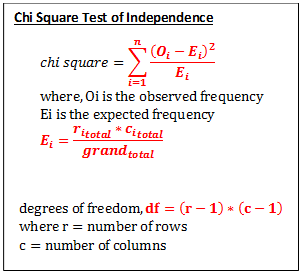

A Chi-Square Test of Independence is used to determine whether or not there is a significant association between two categorical variables.

**Null:** Two samples are independent of each other

**Alternate:** Two samples are not independent of each other




In [85]:
# creating reference and target dataframe with categorical column
d1 = ['A','A','A','A','B','B','C','C','C']
d2 = ['A','A','B','B','B','B','B','C','C']
data_ref = pd.DataFrame(d1, columns=['ticket_category_ref'])
print(data_ref.shape)
display(data_ref)

data_target = pd.DataFrame(d2, columns=['ticket_category_tar'])
print(data_target.shape)
display(data_target)

(9, 1)


,ticket_category_ref
0,A
1,A
2,A
3,A
4,B
5,B
6,C
7,C
8,C


(9, 1)


,ticket_category_tar
0,A
1,A
2,B
3,B
4,B
5,B
6,B
7,C
8,C


In [86]:
cross_tab = pd.crosstab(data_ref.ticket_category_ref,data_target.ticket_category_tar)
cross_tab

ticket_category_tar,A,B,C
ticket_category_ref,,,
A,2,2,0
B,0,2,0
C,0,1,2


In [87]:
# Chi-Square test of independence
# if p < 0.05 then the two categories are not independnt of each other
chi2_stat, pvalue, df, expected_freq = stats.chi2_contingency(cross_tab)
print(pvalue)

0.11170929281604328


In [89]:
# Chi-Square goodness of fit test
# Make sure you have the frequency of each categories in the same order in both observed and expected
# if p < 0.05 then the two frequencies are not from same distribution
expected = data_target.groupby('ticket_category_tar')['ticket_category_tar'].count().values
observed = data_ref.groupby('ticket_category_ref')['ticket_category_ref'].count().values 

chi2_stat, pvalue = stats.chisquare(f_obs=observed,f_exp=expected)
print(pvalue)

0.11648415777349701


In [88]:
data_target.groupby('ticket_category_tar')['ticket_category_tar'].count().values

array([2, 5, 2])

In [81]:
data_ref.groupby('ticket_category_ref')['ticket_category_ref'].count().values 

array([4, 2, 3])